In [ ]:
import rasterio
import numpy as np
import os
import cv2
import numpy as np
import rasterio
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
from shapely.geometry import Polygon
import torch
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import os

# 1. Data Loading
jp2_path = "OTF_VIRGEN_QUINCHE_SUR.jp2"

with rasterio.open(jp2_path) as src:
    img = np.dstack([src.read(i) for i in (1, 2, 3)])  
    transform = src.transform 
    crs       = src.crs

sam = sam_model_registry["vit_b"](checkpoint="sam_vit_b_01ec64.pth")
sam.to(device="cuda")
mask_generator = SamAutomaticMaskGenerator(sam)

mask_gen = SamAutomaticMaskGenerator(sam)
# 2. Tiling parameters
tile_size   = 2048   # 2 k × 2 k pixels per tile
overlap     = 256    # 256 px overlap to catch boundary objects
stride      = tile_size - overlap

H, W, _ = img.shape
all_masks = []

# 3. Slide over the image and generate masks per tile
for y0 in range(0, H, stride):
    for x0 in range(0, W, stride):
        y1 = min(y0 + tile_size, H)
        x1 = min(x0 + tile_size, W)
        tile = img[y0:y1, x0:x1]
        masks = mask_gen.generate(tile)
        for m in masks:
            m["bbox"] = [
                m["bbox"][0] + x0,
                m["bbox"][1] + y0,
                m["bbox"][2],
                m["bbox"][3],
            ]
            all_masks.append(m)

# 4. Heuristic + Strong Color + Shape filtering
min_area, max_area       = 5_000, 200_000    # px
max_aspect               = 4.0
solidity_thresh          = 0.8
rectangularity_thresh    = 0.6
exg_thresh               = 20               # Excess‐Green mean threshold
hsv_veg_ratio_thresh     = 0.3              # Drop if >x% pixels are “green”

candidates = []
for m in all_masks:
    x, y, w, h = [int(v) for v in m["bbox"]]
    area       = m["area"]
    compact    = area / (w*h + 1e-9)
    aspect     = max(w/h, h/w)

    # size & shape
    if not (min_area < area < max_area): continue
    if compact < 0.3:                        continue
    if aspect > max_aspect:                 continue

    # crop patch
    patch = img[y:y+h, x:x+w]
    if patch.mean() < 20:                   continue  # black border

    # 4a) Excess‐Green (ExG = 2G - R - B)
    r, g, b   = patch[...,0], patch[...,1], patch[...,2]
    exg       = (2*g.astype(int) - r.astype(int) - b.astype(int))
    if exg.mean() > exg_thresh:            continue

    # 4b) HSV‐based green mask
    hsv       = cv2.cvtColor(patch, cv2.COLOR_RGB2HSV)
    hue, sat  = hsv[...,0], hsv[...,1]
    veg_mask  = ((hue >= 25) & (hue <= 90) & (sat > 50))
    if veg_mask.mean() > hsv_veg_ratio_thresh: 
        continue

    # 4c) shape filters on the raw mask
    mask_u8   = (m["segmentation"].astype(np.uint8) * 255)
    cnts, _   = cv2.findContours(mask_u8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:                           continue
    cnt       = max(cnts, key=cv2.contourArea)
    area_cnt  = cv2.contourArea(cnt)
    hull_area = cv2.contourArea(cv2.convexHull(cnt))
    solidity  = area_cnt / (hull_area + 1e-9)
    if solidity < solidity_thresh:        continue
    rect      = cv2.minAreaRect(cnt)
    rect_area = rect[1][0] * rect[1][1]
    rectangularity = area_cnt / (rect_area + 1e-9)
    if rectangularity < rectangularity_thresh: 
        continue

    candidates.append(m)

# 5. Non‐Max Suppression (IoU<0.3)
def iou(b1, b2):
    r1 = shapely_box(b1[0],b1[1],b1[0]+b1[2],b1[1]+b1[3])
    r2 = shapely_box(b2[0],b2[1],b2[0]+b2[2],b2[1]+b2[3])
    inter = r1.intersection(r2).area
    return inter / (r1.area + r2.area - inter + 1e-9)

candidates.sort(key=lambda m: m["area"], reverse=True)
houses = []
for m in candidates:
    if all(iou(m["bbox"], h["bbox"]) < 0.3 for h in houses):
        houses.append(m)

🏠 Final house count: 518


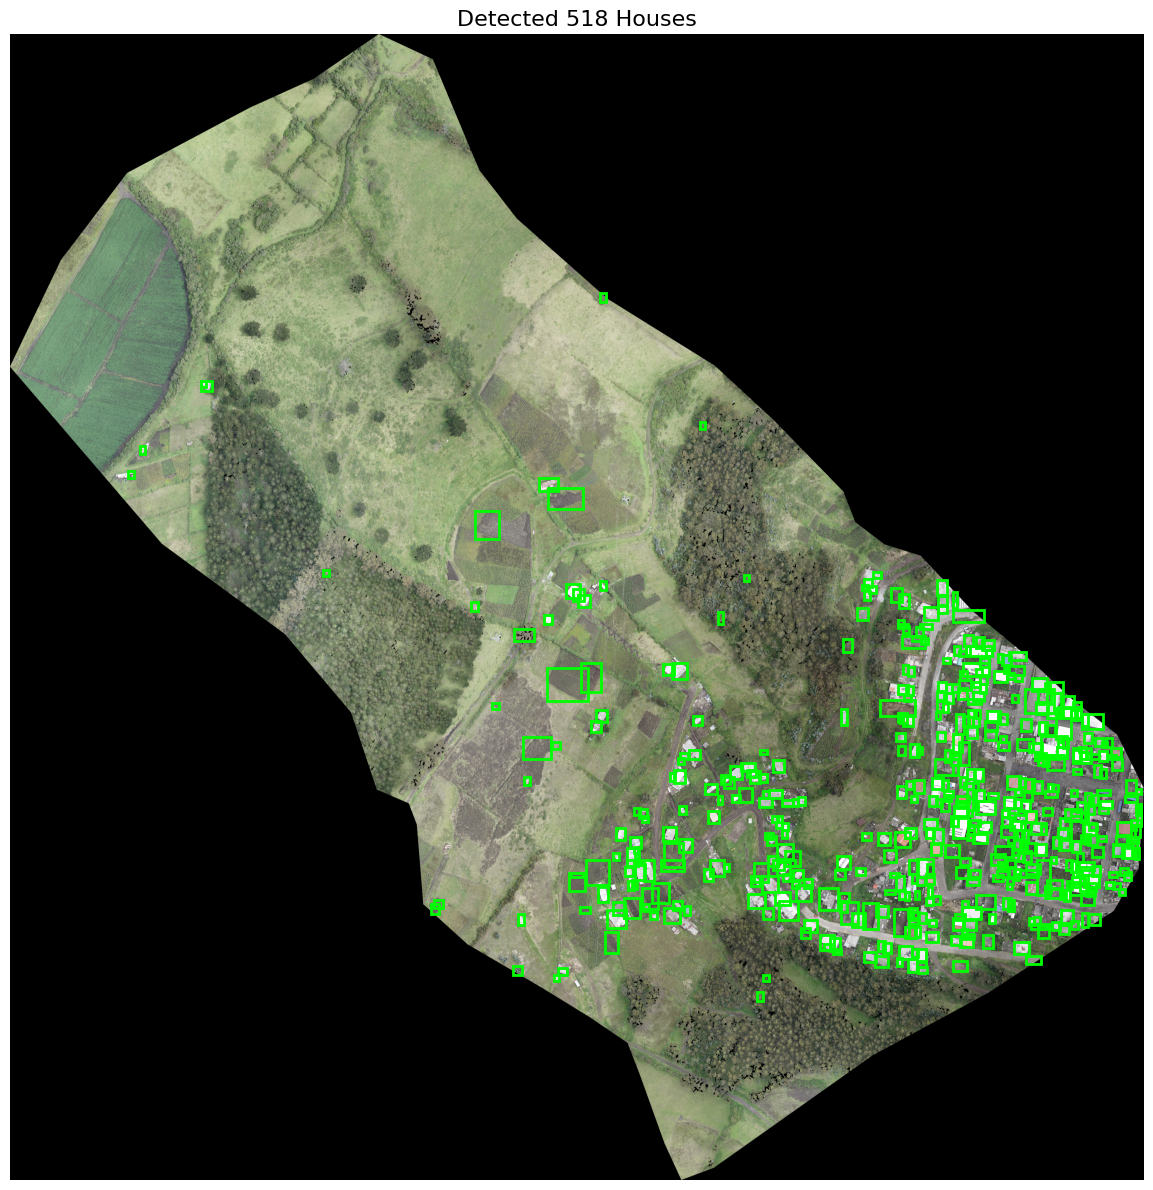

In [ ]:
# 6. Plot
print(f"🏠 Final house count: {len(houses)}")
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(img)
for m in houses:
    x,y,w,h = m["bbox"]
    ax.add_patch(Rectangle((x,y),w,h,linewidth=2,edgecolor="lime",facecolor="none"))
ax.set_title(f"Detected {len(houses)} Houses", fontsize=16)
ax.axis("off")
plt.tight_layout()
plt.show()

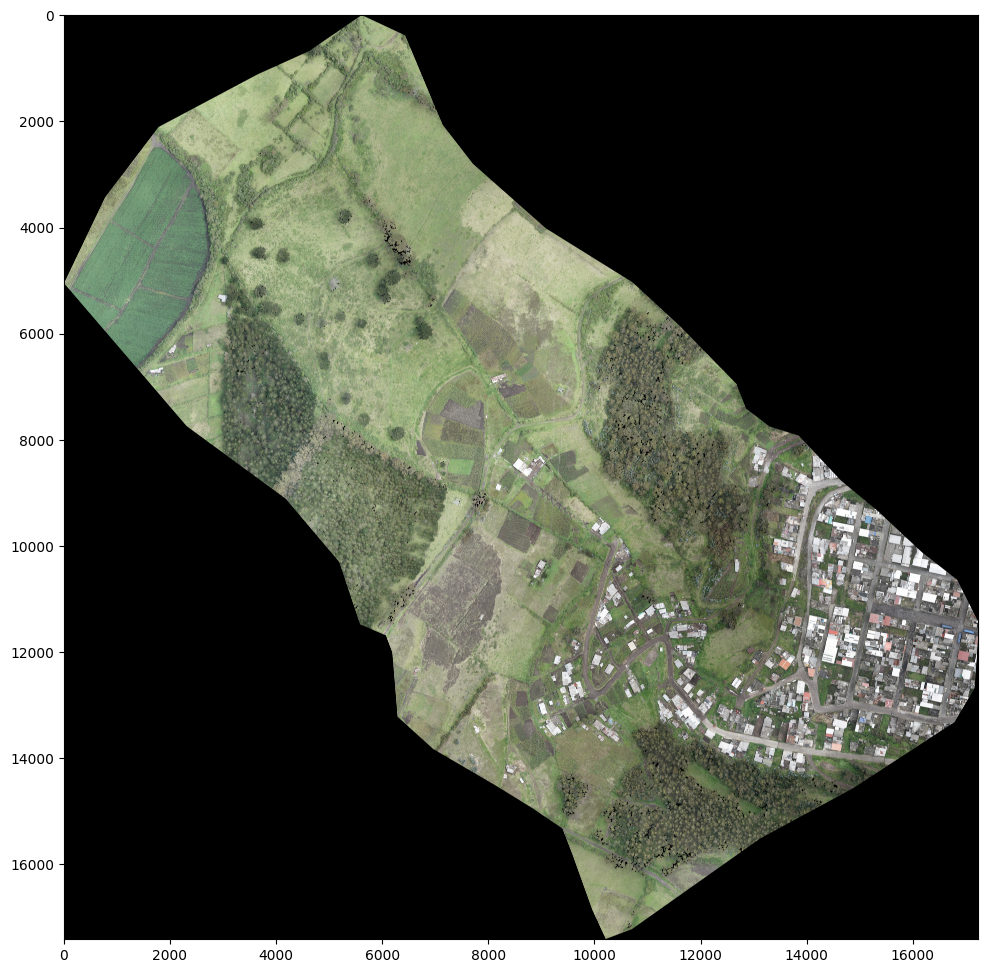

In [ ]:
# 7. Plot original image
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(img)
ax.axis("off")
plt.tight_layout()
plt.show()